# SARC EDA
EDA, Adjustments, Balancing, and Exporting

## Imports & Settings

In [1]:
import os
os.chdir('..')
# os.getcwd( )

In [2]:
from utils import *

import re
import nltk
import string
import numpy as np

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

import datasets
from datasets import load_dataset, load_metric, Dataset

## Load Dataset

Describe dataset

In [3]:
sarc_df = pd.read_csv('data/inter_SARC/source_SARC/train-balanced-sarcasm.csv')
sarc_df = sarc_df.rename(columns={'comment': 'text'})

sarc_df

,label,text,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...
...,...,...,...,...,...,...,...,...,...,...
1010821,1,I'm sure that Iran and N. Korea have the techn...,TwarkMain,reddit.com,2,2,0,2009-04,2009-04-25 00:47:52,"No one is calling this an engineered pathogen,..."
1010822,1,"whatever you do, don't vote green!",BCHarvey,climate,1,1,0,2009-05,2009-05-14 22:27:40,In a move typical of their recent do-nothing a...
1010823,1,Perhaps this is an atheist conspiracy to make ...,rebelcommander,atheism,1,1,0,2009-01,2009-01-11 00:22:57,Screw the Disabled--I've got to get to Church ...
1010824,1,The Slavs got their own country - it is called...,catsi,worldnews,1,1,0,2009-01,2009-01-23 21:12:49,I've always been unsettled by that. I hear a l...


In [4]:
sarc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1010826 entries, 0 to 1010825
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   label           1010826 non-null  int64 
 1   text            1010773 non-null  object
 2   author          1010826 non-null  object
 3   subreddit       1010826 non-null  object
 4   score           1010826 non-null  int64 
 5   ups             1010826 non-null  int64 
 6   downs           1010826 non-null  int64 
 7   date            1010826 non-null  object
 8   created_utc     1010826 non-null  object
 9   parent_comment  1010826 non-null  object
dtypes: int64(4), object(6)
memory usage: 77.1+ MB


In [5]:
# view the positive label to be sure that the indicative "/s"\\\\ has been removed
sarc_text = sarc_df.loc[sarc_df['label'] == 1]
sarc_text.head()

,label,text,author,subreddit,score,ups,downs,date,created_utc,parent_comment
33,1,But they'll have all those reviews!,RoguishPoppet,ProductTesting,0,-1,-1,2016-11,2016-11-01 02:04:59,"The dumb thing is, they are risking their sell..."
44,1,wow it is totally unreasonable to assume that ...,pb2crazy,politics,2,-1,-1,2016-11,2016-11-01 02:42:11,Clinton campaign accuses FBI of 'blatant doubl...
45,1,Ho ho ho... But Melania said that there is no ...,pb2crazy,politics,8,-1,-1,2016-10,2016-10-18 16:20:53,Anyone else think that it was interesting the ...
66,1,I can't wait until @potus starts a twitter war...,kitduncan,politics,3,-1,-1,2016-11,2016-11-01 03:22:33,Here's what happens when Obama gives up his Tw...
69,1,gotta love the teachers who give exams on the ...,DEP61,CFBOffTopic,3,-1,-1,2016-11,2016-11-01 03:30:11,Monday night Drinking thread Brought to You by...


## Remove Null Values

In [6]:
nan_in_comment  = sarc_df[sarc_df['text'].isna()]
nan_in_comment.head()

,label,text,author,subreddit,score,ups,downs,date,created_utc,parent_comment
56269,1,NaN,SodokuIRL,leagueoflegends,1,1,0,2016-09,2016-09-28 08:23:04,"LPL shitshow, EU LCS shitshow. What isn't a sh..."
68590,1,NaN,TossTheDog,westchesterpa,1,-1,-1,2016-10,2016-10-11 20:25:52,Car fires smell delicious to you? You should p...
135348,0,NaN,So12rovv,R6STeams,1,-1,-1,2016-12,2016-12-22 17:24:05,Will do. EU or NA?
199910,0,NaN,Khvostov_7g-02,tf2,1,1,0,2016-05,2016-05-16 05:46:43,"woah, thanks."
258718,1,NaN,PeaceLovePositivity,vaporents,5,5,0,2016-06,2016-06-22 20:37:11,"No, doing drugs while forming a fetus (your ki..."


In [7]:
sarc_df = sarc_df.dropna(subset=['text'])
sarc_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1010773 entries, 0 to 1010825
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   label           1010773 non-null  int64 
 1   text            1010773 non-null  object
 2   author          1010773 non-null  object
 3   subreddit       1010773 non-null  object
 4   score           1010773 non-null  int64 
 5   ups             1010773 non-null  int64 
 6   downs           1010773 non-null  int64 
 7   date            1010773 non-null  object
 8   created_utc     1010773 non-null  object
 9   parent_comment  1010773 non-null  object
dtypes: int64(4), object(6)
memory usage: 84.8+ MB


## Check for Dupes

Below we find that there are not enough dupes to require action, epically considering we will subset this dataset without replacement.

In [8]:
dup_df = sarc_df.loc[sarc_df.duplicated(), :]

dup_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28 entries, 23777 to 800401
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   label           28 non-null     int64 
 1   text            28 non-null     object
 2   author          28 non-null     object
 3   subreddit       28 non-null     object
 4   score           28 non-null     int64 
 5   ups             28 non-null     int64 
 6   downs           28 non-null     int64 
 7   date            28 non-null     object
 8   created_utc     28 non-null     object
 9   parent_comment  28 non-null     object
dtypes: int64(4), object(6)
memory usage: 2.4+ KB


## View Label Distribution
After removing null values, we find a slight imbalance.

[Text(0, 0, '505405'), Text(0, 0, '505368')]

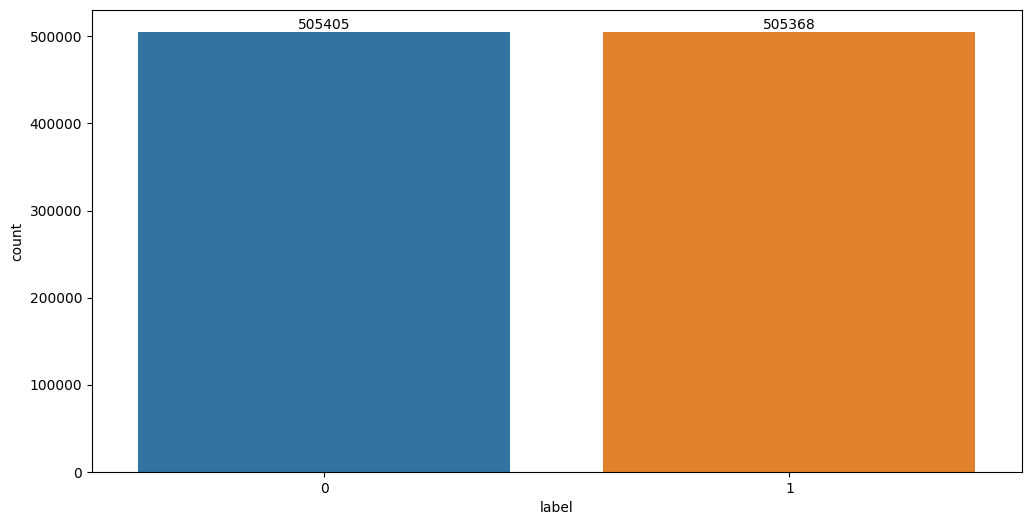

In [9]:
fig = plt.figure(figsize=(12, 6))
ax = sns.countplot(x='label', data=sarc_df)
ax.bar_label(ax.containers[0])

## View Word Counts & Word Count Distribution 

In [10]:
sarc_df['num_word_text'] = sarc_df['text'].apply(lambda x:len(str(x).split()))
sarc_df.head()

/var/folders/99/shh1qrbd2p7bf1bz7xc2lyz00000gn/T/ipykernel_2279/3467025785.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sarc_df['num_word_text'] = sarc_df['text'].apply(lambda x:len(str(x).split()))


,label,text,author,subreddit,score,ups,downs,date,created_utc,parent_comment,num_word_text
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ...",3
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...,14
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.,19
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz,12
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...,7


In [11]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)
sarc_df.describe()

,label,score,ups,downs,num_word_text
count,1010773.00000,1010773.00000,1010773.00000,1010773.00000,1010773.00000
mean,0.49998,6.88600,5.49914,-0.14587,10.46145
std,0.50000,48.34411,41.27402,0.35297,10.53495
min,0.00000,-507.00000,-507.00000,-1.00000,1.00000
25%,0.00000,1.00000,0.00000,0.00000,5.00000
50%,0.00000,2.00000,1.00000,0.00000,9.00000
75%,1.00000,4.00000,3.00000,0.00000,14.00000
max,1.00000,9070.00000,5163.00000,0.00000,2222.00000


### Longest Entries
A outlying set of entries are exceptionally long. We view and remove them.

In [12]:
# check longest entires
pd.options.display.max_colwidth = 200
long_text_df = sarc_df.loc[sarc_df['num_word_text'] > 400]
long_text_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27 entries, 5556 to 975519
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   label           27 non-null     int64 
 1   text            27 non-null     object
 2   author          27 non-null     object
 3   subreddit       27 non-null     object
 4   score           27 non-null     int64 
 5   ups             27 non-null     int64 
 6   downs           27 non-null     int64 
 7   date            27 non-null     object
 8   created_utc     27 non-null     object
 9   parent_comment  27 non-null     object
 10  num_word_text   27 non-null     int64 
dtypes: int64(5), object(6)
memory usage: 2.5+ KB


In [13]:
sarc_df = sarc_df.loc[sarc_df['num_word_text'] <= 400]
sarc_df.describe()

,label,score,ups,downs,num_word_text
count,1010746.00000,1010746.00000,1010746.00000,1010746.00000,1010746.00000
mean,0.50000,6.88608,5.49921,-0.14586,10.42955
std,0.50000,48.34474,41.27455,0.35297,8.07468
min,0.00000,-507.00000,-507.00000,-1.00000,1.00000
25%,0.00000,1.00000,0.00000,0.00000,5.00000
50%,0.00000,2.00000,1.00000,0.00000,9.00000
75%,1.00000,4.00000,3.00000,0.00000,14.00000
max,1.00000,9070.00000,5163.00000,0.00000,381.00000


<AxesSubplot: xlabel='num_word_text', ylabel='Count'>

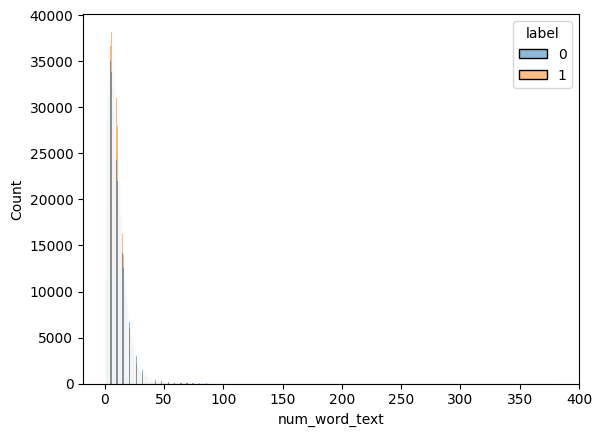

In [14]:
sns.histplot(x="num_word_text", data=sarc_df,  hue="label", palette="tab10")

In [15]:
pd.options.display.max_colwidth = 100
sarc_df['text']

0                                                                                                   NC and NH.
1                                   You do know west teams play against west teams more than east teams right?
2          They were underdogs earlier today, but since Gronk's announcement this afternoon, the Vegas line...
3                                                 This meme isn't funny none of the "new york nigga" ones are.
4                                                                              I could use one of those tools.
                                                          ...                                                 
1010821           I'm sure that Iran and N. Korea have the technology to create a pig/bird/human hybrid virus.
1010822                                                                     whatever you do, don't vote green!
1010823                                     Perhaps this is an atheist conspiracy to make Christians look bad?
1

### Shortest Entries

In [16]:
sarc_df.loc[sarc_df['num_word_text'] == 1]

,label,text,author,subreddit,score,ups,downs,date,created_utc,parent_comment,num_word_text
16,0,noted.,kozmo1313,NewOrleans,2,-1,-1,2016-12,2016-12-20 21:59:45,You're adorable.,1
25,0,466,Cogman117,Overwatch,5,-1,-1,2016-11,2016-11-03 00:20:04,467 A lovely way!,1
30,0,New,KingAetherrr,ClashRoyale,3,-1,-1,2016-11,2016-11-15 04:42:47,but what format,1
35,0,r/fuckyouididthemath,xVamplify,videos,3,-1,-1,2016-12,2016-12-31 16:37:40,This is a great response! Too bad about the lack of accolades.,1
42,0,1571049,RandomRedditorWithNo,counting,1,-1,-1,2016-12,2016-12-17 06:56:28,"1,571,048",1
...,...,...,...,...,...,...,...,...,...,...,...
1010729,0,Indeed.,Tucci,WeAreTheMusicMakers,1,1,0,2009-06,2009-06-24 20:49:23,That she is.,1
1010756,1,Unions?,geneusutwerk,business,3,3,0,2009-04,2009-04-16 13:36:33,Then why are they steadily going down? The average baggage handler used to be able to handle two...,1
1010779,0,Hi,mercurysquad,AskReddit,3,3,0,2009-03,2009-03-14 14:22:17,I don't really need a notifier. The envelope is almost never red/orange. I just want someone to ...,1
1010796,1,ZOMG!,memefilter,911truth,1,1,0,2009-07,2009-07-30 15:44:26,07 - 31 - 2009 7+3+1 = 11 2+9=11 07312009 = 1111,1


#### View Tokenized Length
Below, we find that the tokenized SARC sequences can reach max length but the majority of inputs are quite short.

In [17]:
train_token_id = []

# encode training text
for sample in sarc_df.text.values:
  encoding_dict = preprocessing_dyna(sample, params.tokenizer)
  # parse encoding dict to lists
  train_token_id.append(encoding_dict['input_ids']) 

In [18]:
train_token_id[:2]

[[0, 6905, 8, 18886, 4, 2],
 [0,
  1185,
  109,
  216,
  3072,
  893,
  310,
  136,
  3072,
  893,
  55,
  87,
  3017,
  893,
  235,
  116,
  2]]

In [19]:
lengths = []
for i in train_token_id:
    lengths.append(len(i))

print(len(lengths))
print(lengths[:10])
print(f'Max Tokenized Sequence Length: {max(lengths)}')

1010746
[6, 17, 28, 20, 10, 32, 12, 12, 19, 12]
Max Tokenized Sequence Length: 256


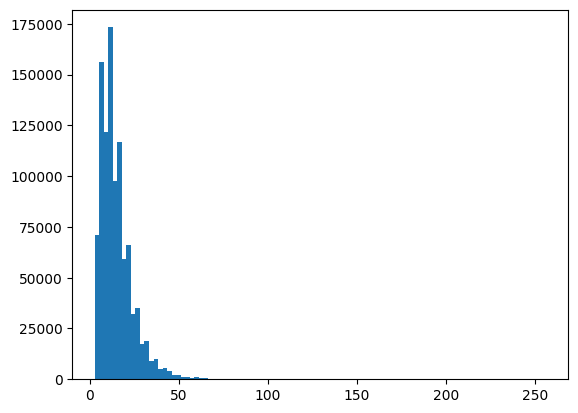

In [20]:
# make a histogram from the lengths
plt.hist(lengths, bins=100)
plt.show()

## Adjust & Export Datasets for Train/Validate/Test
Below we create a training set, validation set, as well as a holdout test set.

In [21]:
# shuffle dataframe and reset index
sarc_df = sarc_df.sample(frac=1, random_state=1).reset_index(drop=True)

sarc_df.head()

,label,text,author,subreddit,score,ups,downs,date,created_utc,parent_comment,num_word_text
0,0,It's just his final lap of this season.,Balder666,motorcycles,9,9,0,2015-11,2015-11-15 12:55:47,"Yea, what happened?",8
1,0,the majority of apple's innovation comes from marketing and advertising.,not-brodie,Android,2,2,0,2015-01,2015-01-28 21:58:29,Apple is highly innovative. For each of their new products the anti-Apple jerks come along and e...,10
2,0,But full chem still = a better performing team unless were saying chemistry styles are useless,nastylep,FIFA,14,14,0,2015-01,2015-01-06 15:33:47,"In theory, yeah -- but the times I have used players out of position (at least 4 chem) I did not...",16
3,1,"Yeah, needs more roided out Americans with shotguns.",cowboyfantastic,xboxone,-10,-10,0,2015-01,2015-01-05 20:12:07,I just can't get into this quirky Japanese shit. I can't take the game seriously.,8
4,1,Un solido articolo di approfondimento.,MonsieurCellophane,italy,5,5,0,2015-11,2015-11-24 19:03:11,Captagon: la pillola dell'orrore,5


In [22]:
sarc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1010746 entries, 0 to 1010745
Data columns (total 11 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   label           1010746 non-null  int64 
 1   text            1010746 non-null  object
 2   author          1010746 non-null  object
 3   subreddit       1010746 non-null  object
 4   score           1010746 non-null  int64 
 5   ups             1010746 non-null  int64 
 6   downs           1010746 non-null  int64 
 7   date            1010746 non-null  object
 8   created_utc     1010746 non-null  object
 9   parent_comment  1010746 non-null  object
 10  num_word_text   1010746 non-null  int64 
dtypes: int64(5), object(6)
memory usage: 84.8+ MB


### Test Split

In [23]:
# sample the dataset
sarc_test = sarc_df.sample(10000, random_state=1)
sarc_test

,label,text,author,subreddit,score,ups,downs,date,created_utc,parent_comment,num_word_text
356962,0,God speed!,dmachin85,sydney,3,-1,-1,2016-12,2016-12-04 22:18:54,"It's all good roomie got here about 30 mins ago, just hoping I don't get a few hours of hold.",2
749272,1,But all anyone cares about is trophy pushing!,MagiicHat,ClashOfClans,-1,-1,0,2015-11,2015-11-12 18:43:24,"When logging on, along with the total number of trophies you won or lost while logged off you sh...",8
688005,0,I meant they don't care what month their new phases start in.,that_guy2010,marvelstudios,1,1,0,2015-05,2015-05-20 05:04:27,They've been pretty insistent that Ant-Man is the end of Phase 2. I think they are pretty invest...,12
667972,0,Wonder who ratted them out,armsch,CFB,1,1,0,2016-01,2016-01-29 19:59:05,Sources: NCAA to formally charge Mississippi with rules violations,5
420140,1,"Alright, so watch every tutorial from 2005 I can find",Luckyloomagu,AskReddit,1,1,0,2016-06,2016-06-17 07:40:42,"Coding is easy, but only if you've got the right mindset. Just gotta find the right tutorial, an...",10
...,...,...,...,...,...,...,...,...,...,...,...
609166,1,How do you have time for an AMA when 1SG briefed you on all your nonstop responsibilities?,ReptarsSingleDaddy,army,8,8,0,2014-12,2014-12-15 14:37:10,"Boredom has already ensued; on CQ, AMA. Was not allowed to put in HBL due to the amount of dutie...",17
814876,1,Its not like we went in there in the first place so bush could finish his daddys war and hook up...,greenphilly420,news,0,0,0,2015-11,2015-11-15 15:23:19,We never tried to build a nation in Iraq. Obama made sure that didnt happen.,31
740855,1,Black lives don't matter.,armchairracer,AskReddit,7,7,0,2016-09,2016-09-19 03:08:40,"Ah yes the old: ""Abortion is murder, unless the baby is black.""",4
289350,0,How drunk am I right now?,rustier_trombone,Rowing,1,1,0,2015-02,2015-02-15 01:38:20,"I'm a black coxswain at a large University club rowing team, AMA. I'd like to say that I am #rar...",6


In [24]:
# remove test set samples from dataset
sarc_df = sarc_df.drop(sarc_test.index)
sarc_df

,label,text,author,subreddit,score,ups,downs,date,created_utc,parent_comment,num_word_text
0,0,It's just his final lap of this season.,Balder666,motorcycles,9,9,0,2015-11,2015-11-15 12:55:47,"Yea, what happened?",8
1,0,the majority of apple's innovation comes from marketing and advertising.,not-brodie,Android,2,2,0,2015-01,2015-01-28 21:58:29,Apple is highly innovative. For each of their new products the anti-Apple jerks come along and e...,10
2,0,But full chem still = a better performing team unless were saying chemistry styles are useless,nastylep,FIFA,14,14,0,2015-01,2015-01-06 15:33:47,"In theory, yeah -- but the times I have used players out of position (at least 4 chem) I did not...",16
3,1,"Yeah, needs more roided out Americans with shotguns.",cowboyfantastic,xboxone,-10,-10,0,2015-01,2015-01-05 20:12:07,I just can't get into this quirky Japanese shit. I can't take the game seriously.,8
4,1,Un solido articolo di approfondimento.,MonsieurCellophane,italy,5,5,0,2015-11,2015-11-24 19:03:11,Captagon: la pillola dell'orrore,5
...,...,...,...,...,...,...,...,...,...,...,...
1010741,0,I don't understand why it shocks so many people to the core when you tell them you'd get an abor...,SunshineButts,childfree,73,73,0,2016-04,2016-04-06 03:09:35,"""Accidents Happen.""",24
1010742,0,A giant bulldog clip at the back of your head?,MartinSchou,pics,-2,-2,0,2014-06,2014-06-02 22:09:00,"Yes it is, but it's not just makeup.",10
1010743,0,Between two Berns.,HoldMyWater,politics,1,1,0,2016-01,2016-01-31 02:32:52,The one who Berns.,3
1010744,0,"There's a phrase leaping into my mind ""depraved indifference""...",fearghul,worldnews,3,3,0,2016-03,2016-03-01 01:05:45,"Cardinal George Pell gives evidence into child sex abuse. ""I knew a number of people ...It was a...",9


### Validation Split

In [25]:
# sample the dataset
sarc_validation = sarc_df.sample(10000, random_state=1)
sarc_validation

,label,text,author,subreddit,score,ups,downs,date,created_utc,parent_comment,num_word_text
771499,1,You misinterpreted that-- he was just giving people gold stars to go to the Reich's theme parks!,theroachsays,SubredditDrama,6,6,0,2013-03,2013-03-04 18:36:02,You know who else tagged people? HITLER,17
387814,1,"Come back to Red, it's getting lonely here",hastagelf,MapPorn,1,1,0,2015-07,2015-07-09 04:33:47,"Born in the red, living in the blue!",8
354926,0,"I drank a Shiner once, sign me up",HOU-1836,MLS,9,9,0,2014-10,2014-10-16 22:11:43,"They should get some Germans to assist with this, I'd be willing to put my hat in there (hire me...",8
760266,1,"Then she should start demanding 40 hour weeks, paid vacation, and sick leave.",itsronnielanelove,relationships,5,-1,-1,2016-11,2016-11-21 20:14:28,"Yes, but that IS her job - not financial input",13
869925,0,There's a new inferno tower barrel coming out,bloaph,ClashRoyale,5,5,0,2016-05,2016-05-09 04:41:50,NEW CARD: Royale Musketeer Chief Pat just revealed this at the end of his stream. New card comin...,8
...,...,...,...,...,...,...,...,...,...,...,...
104246,0,I don't know why but I got a kick out of your comment.,mutt_butt,todayilearned,2,2,0,2015-04,2015-04-28 17:13:41,Then he should've written better. Same with Upton Sinclair and *The Jungle*,13
476019,0,Hooray!,cutthroat_molloy,minipainting,1,1,0,2015-04,2015-04-10 01:22:16,Love 'em!!!,1
760404,1,That phrase triggers me.,xNOM,MensRights,4,4,0,2015-05,2015-05-07 18:45:33,"Read the comments. ""Safe space"" now has priority over everything.",4
728678,0,Yeezy,koolcid999,hiphopheads,0,0,0,2016-01,2016-01-02 16:28:07,"Who are the greatest rappers that aren't considered ""east/west coast""?",1


In [26]:
# remove validation set samples from dataset
sarc_df = sarc_df.drop(sarc_validation.index)
sarc_df


,label,text,author,subreddit,score,ups,downs,date,created_utc,parent_comment,num_word_text
0,0,It's just his final lap of this season.,Balder666,motorcycles,9,9,0,2015-11,2015-11-15 12:55:47,"Yea, what happened?",8
1,0,the majority of apple's innovation comes from marketing and advertising.,not-brodie,Android,2,2,0,2015-01,2015-01-28 21:58:29,Apple is highly innovative. For each of their new products the anti-Apple jerks come along and e...,10
2,0,But full chem still = a better performing team unless were saying chemistry styles are useless,nastylep,FIFA,14,14,0,2015-01,2015-01-06 15:33:47,"In theory, yeah -- but the times I have used players out of position (at least 4 chem) I did not...",16
3,1,"Yeah, needs more roided out Americans with shotguns.",cowboyfantastic,xboxone,-10,-10,0,2015-01,2015-01-05 20:12:07,I just can't get into this quirky Japanese shit. I can't take the game seriously.,8
4,1,Un solido articolo di approfondimento.,MonsieurCellophane,italy,5,5,0,2015-11,2015-11-24 19:03:11,Captagon: la pillola dell'orrore,5
...,...,...,...,...,...,...,...,...,...,...,...
1010741,0,I don't understand why it shocks so many people to the core when you tell them you'd get an abor...,SunshineButts,childfree,73,73,0,2016-04,2016-04-06 03:09:35,"""Accidents Happen.""",24
1010742,0,A giant bulldog clip at the back of your head?,MartinSchou,pics,-2,-2,0,2014-06,2014-06-02 22:09:00,"Yes it is, but it's not just makeup.",10
1010743,0,Between two Berns.,HoldMyWater,politics,1,1,0,2016-01,2016-01-31 02:32:52,The one who Berns.,3
1010744,0,"There's a phrase leaping into my mind ""depraved indifference""...",fearghul,worldnews,3,3,0,2016-03,2016-03-01 01:05:45,"Cardinal George Pell gives evidence into child sex abuse. ""I knew a number of people ...It was a...",9


### Train Split

[Text(0, 0, '495403'), Text(0, 0, '495343')]

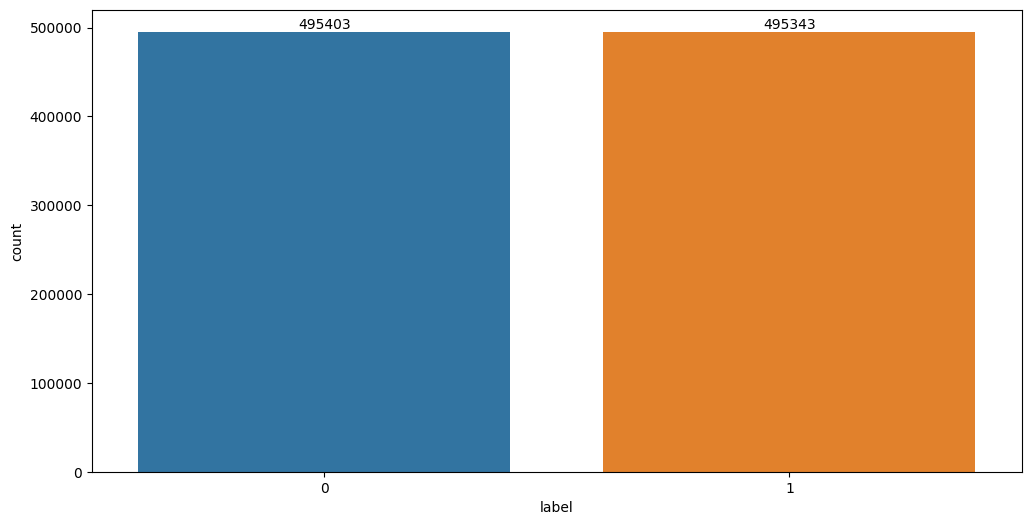

In [27]:
fig = plt.figure(figsize=(12, 6))
ax = sns.countplot(x='label', data=sarc_df)
ax.bar_label(ax.containers[0])

In [28]:
# get 40,000 samples from each class
sarc_train = sarc_df.groupby('label', group_keys=False).apply(lambda x: x.sample(40000, random_state=1))
sarc_train

,label,text,author,subreddit,score,ups,downs,date,created_utc,parent_comment,num_word_text
159705,0,Coito interrotto.,Spaturno,italy,1,1,0,2015-05,2015-05-14 12:31:31,Stranamente in studio c'era Salvini,2
583003,0,Or he is fishing for a 'do not call us' interview from a skunk works group at DHS.,vtjohnhurt,science,3,3,0,2014-04,2014-04-05 17:25:26,I reckon this guy is aiming for an IG noble award,18
973162,0,"Ralph Wiggum, you simple little bugger, I choo choo choose you.",ImProperCrazyMeLike,AskReddit,1,1,0,2016-06,2016-06-06 20:54:31,Who is the best secondary Simpsons character?,11
771413,0,Awesome!,AIMMOTH666,glitch_art,1,1,0,2016-03,2016-03-12 17:51:22,Collapse of the Soul,1
521943,0,can you link the vine?,SagginDragon,tipofmytongue,1,1,0,2015-02,2015-02-11 03:48:53,Song I heard in a Vine Hey guys! I found a vine the other day that used a kind of dubsteppy song...,5
...,...,...,...,...,...,...,...,...,...,...,...
867742,1,siiiiick!,lost_but_crowned,DestinyTheGame,1,1,0,2015-01,2015-01-06 06:23:34,All you do is switch characters..,1
983721,1,He totally thinks you dig him.,daniell61,AskReddit,1,1,0,2013-11,2013-11-15 18:27:17,"I don't have a poker face so I think it went more like, ""well that *is* small I mean uhh.. it's ...",6
940492,1,Your lack of respect for cultural diversity is appauling!,garlicroastedpotato,canada,-2,-2,0,2015-12,2015-12-07 18:33:46,Little girls are not adult women. Well not in my society.,9
131146,1,"Yes, because the desktop version makes **SOO** much sense.",djseptic,AskReddit,1,1,0,2016-09,2016-09-22 03:18:17,"RIP non-mobile users. It's actually more bizarre on mobile, because it just doesn't make any sense.",9


In [29]:
max(sarc_train["num_word_text"])

200

### Double-Check Distribution
Our training set distribution is perfectly balanced while our validation and test sets are representative of the original dataset's distribution.

Text(0.5, 1.0, 'Train Set Label Distribution')

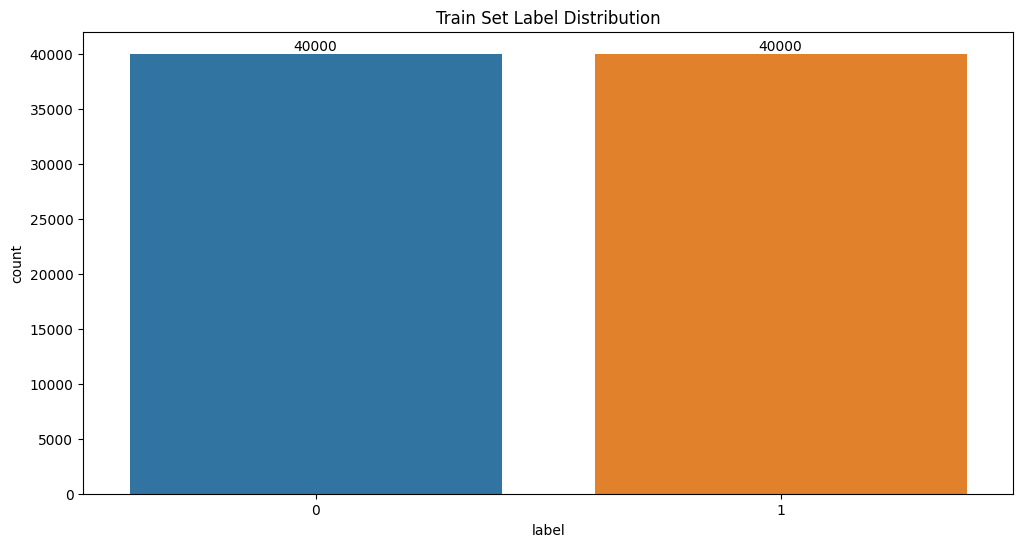

In [36]:
fig = plt.figure(figsize=(12, 6))
ax = sns.countplot(x='label', data=sarc_train)
ax.bar_label(ax.containers[0])
plt.title("Train Set Label Distribution")

Text(0.5, 1.0, 'Validation Set Label Distribution')

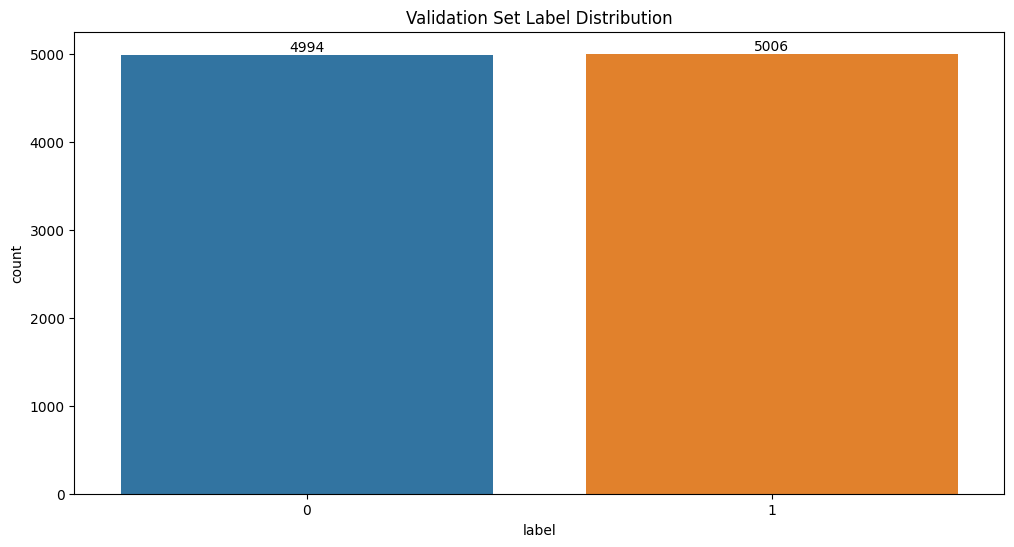

In [37]:
fig = plt.figure(figsize=(12, 6))
ax = sns.countplot(x='label', data=sarc_validation)
ax.bar_label(ax.containers[0])
plt.title("Validation Set Label Distribution")

Text(0.5, 1.0, 'Test Set Label Distribution')

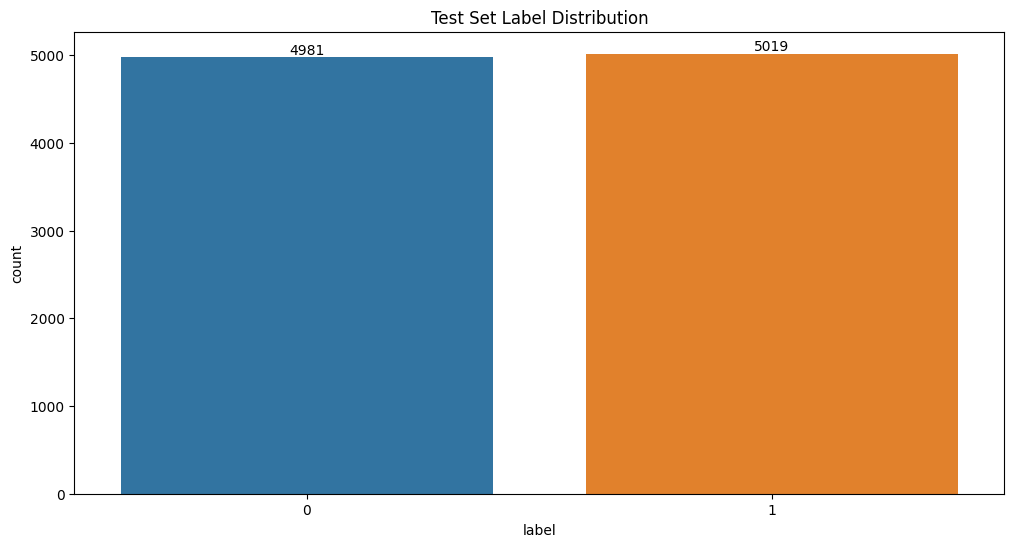

In [35]:
fig = plt.figure(figsize=(12, 6))
ax = sns.countplot(x='label', data=sarc_test)
ax.bar_label(ax.containers[0])
plt.title("Test Set Label Distribution")

## Export Datasets

In [32]:
# reconstitute the updated datafames into a DatasetDict object
train_dataset = Dataset.from_pandas(sarc_train, preserve_index=False)
validate_dataset = Dataset.from_pandas(sarc_validation, preserve_index=False)
test_dataset = Dataset.from_pandas(sarc_test, preserve_index=False)
sarc_datasets = datasets.DatasetDict({"train": train_dataset, 
                                     "validation":validate_dataset, 
                                     "test":test_dataset})

In [33]:
sarc_datasets

DatasetDict({
    train: Dataset({
        features: ['label', 'text', 'author', 'subreddit', 'score', 'ups', 'downs', 'date', 'created_utc', 'parent_comment', 'num_word_text'],
        num_rows: 80000
    })
    validation: Dataset({
        features: ['label', 'text', 'author', 'subreddit', 'score', 'ups', 'downs', 'date', 'created_utc', 'parent_comment', 'num_word_text'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['label', 'text', 'author', 'subreddit', 'score', 'ups', 'downs', 'date', 'created_utc', 'parent_comment', 'num_word_text'],
        num_rows: 10000
    })
})

In [34]:
sarc_datasets.save_to_disk("data/inter_SARC/itesd_sarc_balanced.hf")

Saving the dataset (0/1 shards):   0%|          | 0/80000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/10000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/10000 [00:00<?, ? examples/s]